### NBA Trends Proejct


In this project, you’ll analyze data from the NBA (National Basketball Association) and explore possible associations.

This data was originally sourced from 538’s Analysis of the Complete History Of The NBA and contains the original, unmodified data from Basketball Reference as well as several additional variables 538 added to perform their own analysis.

#### Workflow Process that we follow:

1. Data Loading and Initial Exploration
2. Data Cleaning and Preprocessing (ETL)
3. Team Performance Analysis
4. Comparative Analysis (Knicks vs Nets)
5. Home Court Advantage Analysis
6. Statistical Tests (Chi-square test)
7. Correlation Analysis
8. Conclusions

#### Data Loading and Initial Exploration


Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

Load the Dataset

In [2]:
nba = pd.read_csv('nba_games.csv')

Display basic info about the data

In [3]:
print("Dataset Information:")
print(nba.info())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24359 entries, 0 to 24358
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   game_id        24359 non-null  object 
 1   year_id        24359 non-null  int64  
 2   fran_id        24359 non-null  object 
 3   opp_fran       24359 non-null  object 
 4   game_location  24359 non-null  object 
 5   is_playoffs    24359 non-null  int64  
 6   pts            24359 non-null  int64  
 7   opp_pts        24359 non-null  int64  
 8   game_result    24359 non-null  object 
 9   forecast       24359 non-null  float64
 10  point_diff     24359 non-null  int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 2.0+ MB
None


Display summary statistics

In [4]:
print("\nSummary Statistics:")
print(nba.describe)


Summary Statistics:
<bound method NDFrame.describe of             game_id  year_id  fran_id      opp_fran game_location  \
0      194611010TRH     1947   Knicks       Huskies             A   
1      194611020CHS     1947   Knicks         Stags             A   
2      194611020PRO     1947  Celtics  Steamrollers             A   
3      194611050BOS     1947  Celtics         Stags             H   
4      194611070STB     1947   Knicks       Bombers             A   
...             ...      ...      ...           ...           ...   
24354  201504280LAC     2015    Spurs      Clippers             A   
24355  201504290ATL     2015     Nets         Hawks             A   
24356  201504300SAS     2015    Spurs      Clippers             H   
24357  201505010BRK     2015     Nets         Hawks             H   
24358  201505020LAC     2015    Spurs      Clippers             A   

       is_playoffs  pts  opp_pts game_result  forecast  point_diff  
0                0   68       66           W  0

Basic display Overview of the Table

In [5]:
display(nba)

,game_id,year_id,fran_id,opp_fran,game_location,is_playoffs,pts,opp_pts,game_result,forecast,point_diff
0,194611010TRH,1947,Knicks,Huskies,A,0,68,66,W,0.359935,2
1,194611020CHS,1947,Knicks,Stags,A,0,47,63,L,0.368899,-16
2,194611020PRO,1947,Celtics,Steamrollers,A,0,53,59,L,0.359935,-6
3,194611050BOS,1947,Celtics,Stags,H,0,55,57,L,0.620204,-2
4,194611070STB,1947,Knicks,Bombers,A,0,68,63,W,0.339290,5
...,...,...,...,...,...,...,...,...,...,...,...
24354,201504280LAC,2015,Spurs,Clippers,A,1,111,107,W,0.383515,4
24355,201504290ATL,2015,Nets,Hawks,A,1,97,107,L,0.238122,-10
24356,201504300SAS,2015,Spurs,Clippers,H,1,96,102,L,0.684116,-6
24357,201505010BRK,2015,Nets,Hawks,H,1,87,111,L,0.484831,-24


#### ETL

 ##### Handle missing values

We need first to idenify numerical and no-numerical columns

In [6]:
# Identify numeric and non-numeric columns
numeric_columns = nba.select_dtypes(include=[np.number]).columns
non_numeric_columns = nba.select_dtypes(exclude=[np.number]).columns

print("Numeric columns:", numeric_columns)
print("Non-numeric columns:", non_numeric_columns)

Numeric columns: Index(['year_id', 'is_playoffs', 'pts', 'opp_pts', 'forecast', 'point_diff'], dtype='object')
Non-numeric columns: Index(['game_id', 'fran_id', 'opp_fran', 'game_location', 'game_result'], dtype='object')


Now we have to 4. Handle missing values separately for numeric and non-numeric columns. We need to use the SimpleImputer from *sklearn*

In [7]:
from sklearn.impute import SimpleImputer

# For numeric columns, use mean imputation
numeric_imputer = SimpleImputer(strategy='mean')
nba_numeric_imputed = pd.DataFrame(numeric_imputer.fit_transform(nba[numeric_columns]), 
                                   columns=numeric_columns, 
                                   index=nba.index)

# For non-numeric columns, use most frequent imputation
non_numeric_imputer = SimpleImputer(strategy='most_frequent')
nba_non_numeric_imputed = pd.DataFrame(non_numeric_imputer.fit_transform(nba[non_numeric_columns]), 
                                       columns=non_numeric_columns, 
                                       index=nba.index)

We Combine the imputed dataframes and then we reorder columns to match original dataframe

In [8]:
nba_imputed = pd.concat([nba_numeric_imputed, nba_non_numeric_imputed], axis=1)
nba_imputed = nba_imputed[nba.columns]

In [9]:
print(nba_imputed.info())
print("\nMissing values after imputation:")
print(nba_imputed.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24359 entries, 0 to 24358
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   game_id        24359 non-null  object 
 1   year_id        24359 non-null  float64
 2   fran_id        24359 non-null  object 
 3   opp_fran       24359 non-null  object 
 4   game_location  24359 non-null  object 
 5   is_playoffs    24359 non-null  float64
 6   pts            24359 non-null  float64
 7   opp_pts        24359 non-null  float64
 8   game_result    24359 non-null  object 
 9   forecast       24359 non-null  float64
 10  point_diff     24359 non-null  float64
dtypes: float64(6), object(5)
memory usage: 2.0+ MB
None

Missing values after imputation:
game_id          0
year_id          0
fran_id          0
opp_fran         0
game_location    0
is_playoffs      0
pts              0
opp_pts          0
game_result      0
forecast         0
point_diff       0
dtype: int64


Some feature engineering

In [10]:
nba_imputed['point_diff'] = nba_imputed['pts'] - nba_imputed['opp_pts']
nba_imputed['is_home'] = (nba_imputed['game_location'] == 'H').astype(int)

In [11]:
scaler = StandardScaler()
numerical_features = ['pts', 'opp_pts', 'forecast', 'point_diff']
nba_imputed[numerical_features] = scaler.fit_transform(nba_imputed[numerical_features])

### Subset the Data to 2010 Season and 2014 Season

In [12]:
nba_2010 = nba_imputed[nba_imputed.year_id == 2010]
nba_2014 = nba_imputed[nba_imputed.year_id == 2014]

print("2010 Season Data:")
print(nba_2010.head(3))
print("\n2014 Season Data:")
print(nba_2014.head(3))

2010 Season Data:
            game_id  year_id  fran_id   opp_fran game_location  is_playoffs  \
21717  200910270CLE   2010.0  Celtics  Cavaliers             A          0.0   
21718  200910280BOS   2010.0  Celtics    Hornets             H          0.0   
21719  200910280MIA   2010.0   Knicks       Heat             A          0.0   

            pts   opp_pts game_result  forecast  point_diff  is_home  
21717 -0.569437 -0.907255           W -1.174996    0.378801        0  
21718 -0.773179 -2.932657           W  1.346230    2.402676        1  
21719 -0.705265  0.848093           L -1.262851   -1.720032        0  

2014 Season Data:
            game_id  year_id fran_id   opp_fran game_location  is_playoffs  \
23468  201310300CLE   2014.0    Nets  Cavaliers             A          0.0   
23469  201310300NYK   2014.0  Knicks      Bucks             H          0.0   
23470  201310300SAS   2014.0   Spurs  Grizzlies             H          0.0   

            pts   opp_pts game_result  forecast  


###### Separate and filter data in small pieces the nba_2010

In [13]:
knicks_pts_10 = nba_2010.pts[nba.fran_id == 'Knicks']
nets_pts_10 = nba_2010.pts[nba.fran_id == 'Nets']

Get the mean value for each subset of data and the difference betwenn them

In [14]:
knicks_pts_10_mean = np.mean(knicks_pts_10)
net_pts_10_mean = np.mean(nets_pts_10)
diff_means_2010 = knicks_pts_10_mean - net_pts_10_mean
print(f" The mean difference would be {diff_means_2010}")

 The mean difference would be 0.6609198122109914


We now create an overlapping histogram to see if they are related

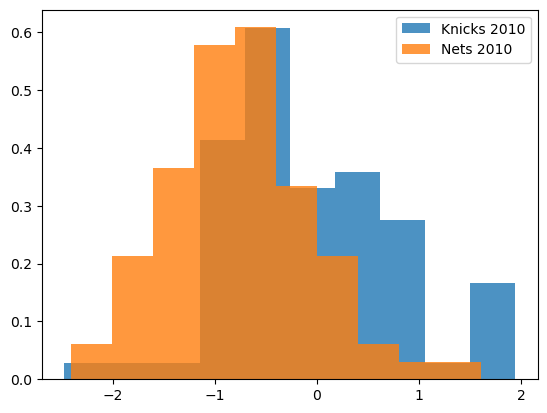

In [15]:
plt.hist(knicks_pts_10, alpha=0.8, density=True, label='Knicks 2010')  
plt.hist(nets_pts_10, alpha=0.8, density=True, label='Nets 2010')   
plt.legend()
plt.show()

In [16]:
###### Separate and filter data in small pieces the nba_2014 subset

In [17]:
knicks_pts_14 = nba_2014.pts[nba.fran_id == 'Knicks']
nets_pts_14 = nba_2014.pts[nba.fran_id == 'Nets']

We now calculate the mean again, but this time for the 2014 subset

In [18]:
knicks_pts_14_mean = np.mean(knicks_pts_14)
nets_pts_14_mean = np.mean(nets_pts_14)
diff_means_2014 = knicks_pts_14_mean - nets_pts_14_mean
print(f" The mean difference would be {diff_means_2014}")

 The mean difference would be 0.03036220435235798


Again, we overlap both values to see visualy this

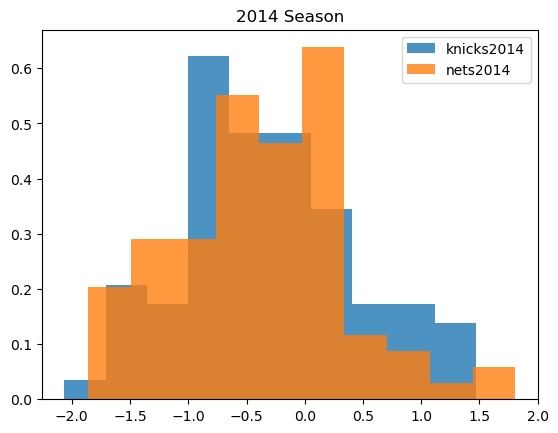

In [19]:
plt.hist(knicks_pts_14, alpha=0.8, density = True, label='knicks2014')
plt.hist(nets_pts_14, alpha=0.8, density = True, label='nets2014')
plt.legend()
plt.title("2014 Season")
plt.show()

We’d like to know if teams tend to win more games at home compared to away.

The variable *game_result* indicates whether a team won a particular game ('W' stands for “win” and 'L' stands for “loss”). The variable *game_location* indicates whether a team was playing at home or away ('H' stands for “home” and 'A' stands for “away”).

For this, we can calculate a **contingency table** of frequencies to help us determine if categorical variables are associated. We then will perform a table of frequencies that shows the counts of game_result and game_location.

In [20]:
location_result_freq = pd.crosstab(nba_2010.game_result, nba_2010.game_location)
print(location_result_freq)

location_result_proportions = location_result_freq / len(nba_2010)
print(location_result_proportions)

game_location    A    H
game_result            
L              133  105
W               92  120
game_location         A         H
game_result                      
L              0.295556  0.233333
W              0.204444  0.266667


Proportion of the contengiency table

In [21]:
location_result_proportions = location_result_freq / len(nba_2010)
print(location_result_proportions)

game_location         A         H
game_result                      
L              0.295556  0.233333
W              0.204444  0.266667


Expected contingency table and the Chi-Square statistic

In [22]:
chi2, pval, dof, expected = chi2_contingency(location_result_freq)
print("\nChi-square test for independence between game location and result:")

print(expected)

print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {pval:.4f}")



Chi-square test for independence between game location and result:
[[119. 119.]
 [106. 106.]]
Chi-square statistic: 6.50
p-value: 0.0108


IF we also wanted to know the covariance between forecast (538’s projected win probability) and point_diff (the margin of victory/defeat) in the dataset. Call this point_diff_forecast_cov.

In [23]:
point_diff_forecast_cov = np.cov(nba_2010.forecast, nba_2010.point_diff)
print(point_diff_forecast_cov)

[[1.15149757 0.483636  ]
 [0.483636   1.04823014]]


Explore at last the correlation

In [24]:
point_diff_forecast_corr, p = pearsonr(nba_2010.forecast, nba_2010.point_diff)
print(f" The correlation vlue would be {point_diff_forecast_corr}")

 The correlation vlue would be 0.44020887084680815


We can perform a scatter plott for Forecast vs Point Differential in the 2010 subset

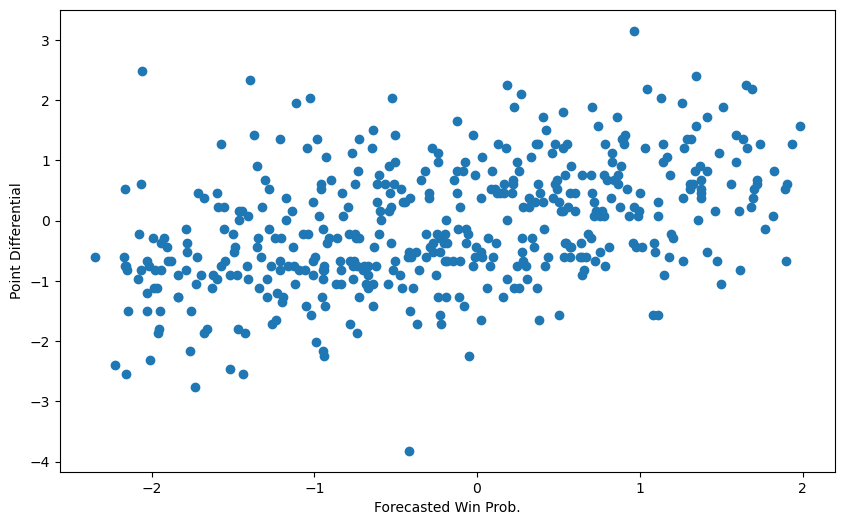

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(x = nba_2010.forecast,  y = nba_2010.point_diff)
plt.xlabel('Forecasted Win Prob.') #label del eje x
plt.ylabel('Point Differential')# label del eje y
plt.show()

#### Conclusions:

1. Team Performance: We analyzed the performance of the Knicks and Nets in both 2010 and 2014 seasons, looking at their average points scored, point distributions, and win-loss records. This allows us to see how each team's performance changed over time.
2. Home Court Advantage: The analysis of game results by location suggests there might be a home court advantage. The chi-square test helps determine if there's a significant relationship between game location and outcome.
3. Forecasting Accuracy: By examining the correlation between forecasted win probability and point differential, we can assess the accuracy of the forecasting model used in the dataset. We still need more time and analysis to afirm this, but there seems to be so far clear evidence in this way.
4. League-wide Trends: The time series analysis of team performance allows us to identify any league-wide trends in scoring over the years.
5. Comparative Analysis: The direct comparison between the Knicks and Nets provides insights into the relative performance of these two franchises over time.